In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from py_helpers.db_helper import *

In [2]:
target = 'playoff'
cleaned_data = './db/WNBA_cleared.db'
tables = ['Awards_Players', 'Coaches', 'Players', 'Players_Teams', 'Teams', 'Teams_Year']

In [3]:
# Retrieve data from the tables in the database
awards_players_df = retrieve_data(cleaned_data, tables[0])  
coaches_df = retrieve_data(cleaned_data, tables[1])  
players_df = retrieve_data(cleaned_data, tables[2])  
players_teams_df = retrieve_data(cleaned_data, tables[3])  
teams_df = retrieve_data(cleaned_data, tables[4])  
teams_year_df = retrieve_data(cleaned_data, tables[5])  


In [4]:
# Feature Selection based on domain knowledge (not using 'pos' playoffs values)

# Features to use for the Teams table
features_teams = ['year','tmID','rank','playoff',
                  'o_fgm','o_fga','o_ftm','o_fta','o_3pm','o_3pa','o_oreb','o_dreb','o_reb','o_asts','o_pf','o_stl','o_to','o_blk','o_pts',
                  'd_fgm','d_fga','d_ftm','d_fta','d_3pm','d_3pa','d_oreb','d_dreb','d_reb','d_asts','d_pf','d_stl','d_to','d_blk','d_pts',
                  'homeW','homeL','awayW','awayL'] + ['won', 'lost', 'attend']
teams_df = teams_df[features_teams]

# Features to use for the Players_Team table
features_player_teams = ['playerID','year','stint','tmID','GP','GS','minutes','points','oRebounds','dRebounds','rebounds','assists','steals','blocks','turnovers','PF','fgRatio','ftRatio','threeRatio','dq']
players_teams_df = players_teams_df[features_player_teams]

# Features to use for the Coaches table
features_coaches = ["coachID","year","tmID","stint","won","lost"]
coaches_df = coaches_df[features_coaches]

In [5]:
# Features to use for the Players table
features_player = ['bioID','pos','height','weight','birthDate']

# Selecting features for teams_df
players_df = players_df[features_player]

# Replacing invalid dates with NaN
players_df['birthDate'] = players_df['birthDate'].replace('0000-00-00', np.nan)

# Converting to birthYear and dropping birthDate
players_df['birthYear'] = pd.to_datetime(players_df['birthDate']).dt.year
players_df['birthYear'] = players_df['birthYear'].astype('Int64')
players_df.drop('birthDate', axis=1, inplace=True)

# One-hot encoding for 'pos'
players_df = pd.get_dummies(players_df, columns=['pos'])

players_df.head()

,bioID,height,weight,birthYear,pos_C,pos_C-F,pos_F,pos_F-C,pos_F-G,pos_G,pos_G-F
0,abrahta01w,74.0,190,1975,1,0,0,0,0,0,0
1,abrossv01w,74.0,169,1980,0,0,1,0,0,0,0
2,adairje01w,76.0,197,1986,1,0,0,0,0,0,0
3,adamsda01w,73.0,239,1989,0,0,0,1,0,0,0
4,adamsjo01w,75.0,180,1981,1,0,0,0,0,0,0


In [6]:
# Selecting features for Awards_Players table
# Removed 'Coach of the Year' because it is not a player award
features_awards_players = ['playerID','year','All-Star Game Most Valuable Player','Defensive Player of the Year', 'Kim Perrot Sportsmanship Award','Most Improved Player','Most Valuable Player','Rookie of the Year','Sixth Woman of the Year','WNBA All Decade Team Honorable Mention','WNBA All-Decade Team','WNBA Finals Most Valuable Player']
 
# Replace spaces with underscores in the column names
for i in range(len(features_awards_players)):
    features_awards_players[i] = features_awards_players[i].replace(' ', '_')
    features_awards_players[i] = features_awards_players[i].replace('-', '_')

# Selecting features for awards_players_df
awards_players_df = awards_players_df[features_awards_players]

# Add feature 'any_award' to awards_players_df
# awards_players_df['any_award'] = awards_players_df[features_awards_players[2:]].notnull().any(axis=1)
# this was not useful because this table only have awards, so all the values are True

combined = {}
# Group by 'playerID' and combine the columns for each feature

for feature in features_awards_players[2:]:
    awards_players_df[feature] = awards_players_df.groupby(['playerID', 'year'])[feature].transform('max')


# Drop duplicate rows
awards_players_df = awards_players_df.drop_duplicates()

awards_players_df.head()

,playerID,year,All_Star_Game_Most_Valuable_Player,Defensive_Player_of_the_Year,Kim_Perrot_Sportsmanship_Award,Most_Improved_Player,Most_Valuable_Player,Rookie_of_the_Year,Sixth_Woman_of_the_Year,WNBA_All_Decade_Team_Honorable_Mention,WNBA_All_Decade_Team,WNBA_Finals_Most_Valuable_Player
0,thompti01w,1,1,0,0,0,0,0,0,0,0,0
1,leslili01w,2,1,0,0,0,1,0,0,0,0,1
2,leslili01w,3,1,0,0,0,0,0,0,0,0,1
3,teaslni01w,4,1,0,0,0,0,0,0,0,0,0
4,swoopsh01w,6,1,0,0,0,1,0,0,0,0,0


In [7]:
# Teams_Year table setup

# Reverses one-hot encoding to get the coachID (could be or not useful)
def get_coachID():
    coachID = teams_year_df[teams_year_df.columns.to_list()[7:]].idxmax(axis=1)
    # Drop the one-hot encoded columns
    teams_year_df.drop(teams_year_df.columns.to_list()[6:], axis=1, inplace=True)
    # Add the coachID column to the DataFrame
    teams_year_df['coachID'] = coachID
    teams_year_df.drop('coachID', axis=1, inplace=True)

get_coachID()
teams_year_df.head()

,year,tmID,totalPoints,cumulativePoints,totalMinutes,yearlyWins
0,1,ATL,0,0,0,0
1,2,ATL,0,0,0,0
2,3,ATL,0,0,0,0
3,4,ATL,0,0,0,0
4,5,ATL,0,0,0,0


In [8]:
# Join the DataFrames
merged_df = teams_df.merge(players_teams_df, on=['year', 'tmID'], how='left') \
                   .merge(players_df, left_on='playerID', right_on='bioID', how='left') \
                   .merge(coaches_df, on=['year', 'tmID'], how='left') \
                   .merge(awards_players_df, on=['playerID', 'year'], how='left') \
                   .merge(teams_year_df, on=['year', 'tmID'], how='left')
merged_df.head()
# This will merge all the DataFrames based on their respective common columns.

,year,tmID,rank,playoff,o_fgm,o_fga,o_ftm,o_fta,o_3pm,o_3pa,...,Most_Valuable_Player,Rookie_of_the_Year,Sixth_Woman_of_the_Year,WNBA_All_Decade_Team_Honorable_Mention,WNBA_All_Decade_Team,WNBA_Finals_Most_Valuable_Player,totalPoints,cumulativePoints,totalMinutes,yearlyWins
0,9,ATL,7,0,895,2258,542,725,202,598,...,NaN,NaN,NaN,NaN,NaN,NaN,2314,2314,6364,4
1,9,ATL,7,0,895,2258,542,725,202,598,...,NaN,NaN,NaN,NaN,NaN,NaN,2314,2314,6364,4
2,9,ATL,7,0,895,2258,542,725,202,598,...,NaN,NaN,NaN,NaN,NaN,NaN,2314,2314,6364,4
3,9,ATL,7,0,895,2258,542,725,202,598,...,NaN,NaN,NaN,NaN,NaN,NaN,2314,2314,6364,4
4,9,ATL,7,0,895,2258,542,725,202,598,...,NaN,NaN,NaN,NaN,NaN,NaN,2314,2314,6364,4


In [9]:
print(merged_df.columns.to_list())

# [
# 'year', 'tmID', 'rank', 'playoff', 'o_fgm', 'o_fga', 'o_ftm', 'o_fta', 'o_3pm', 'o_3pa', 'o_oreb', 'o_dreb', 'o_reb', 'o_asts', 'o_pf', 'o_stl', 'o_to', 'o_blk', 'o_pts', 'd_fgm', 'd_fga', 'd_ftm', 'd_fta', 'd_3pm', 'd_3pa', 'd_oreb', 'd_dreb', 'd_reb', 'd_asts', 'd_pf', 'd_stl', 'd_to', 'd_blk', 'd_pts', 'homeW', 'homeL', 'awayW', 'awayL',
# 'playerID', 'stint_x', 'GP', 'GS', 'minutes', 'points', 'oRebounds', 'dRebounds', 'rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'PF', 'fgRatio', 'ftRatio', 'threeRatio', 'dq',
# 'bioID', 'height', 'weight', 'birthYear', 'pos_C', 'pos_C_F', 'pos_F', 'pos_F_C', 'pos_F_G', 'pos_G', 'pos_G_F',
# 'coachID', 'stint_y', 'won', 'lost',
# 'All_Star_Game_Most_Valuable_Player', 'Coach_of_the_Year', 'Defensive_Player_of_the_Year', 'Kim_Perrot_Sportsmanship_Award', 'Most_Improved_Player', 'Most_Valuable_Player', 'Rookie_of_the_Year', 'Sixth_Woman_of_the_Year', 'WNBA_All_Decade_Team_Honorable_Mention', 'WNBA_All_Decade_Team', 'WNBA_Finals_Most_Valuable_Player',
# 'totalPoints', 'cumulativePoints', 'totalMinutes', 'yearlyWins'
# ]

['year', 'tmID', 'rank', 'playoff', 'o_fgm', 'o_fga', 'o_ftm', 'o_fta', 'o_3pm', 'o_3pa', 'o_oreb', 'o_dreb', 'o_reb', 'o_asts', 'o_pf', 'o_stl', 'o_to', 'o_blk', 'o_pts', 'd_fgm', 'd_fga', 'd_ftm', 'd_fta', 'd_3pm', 'd_3pa', 'd_oreb', 'd_dreb', 'd_reb', 'd_asts', 'd_pf', 'd_stl', 'd_to', 'd_blk', 'd_pts', 'homeW', 'homeL', 'awayW', 'awayL', 'won_x', 'lost_x', 'attend', 'playerID', 'stint_x', 'GP', 'GS', 'minutes', 'points', 'oRebounds', 'dRebounds', 'rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'PF', 'fgRatio', 'ftRatio', 'threeRatio', 'dq', 'bioID', 'height', 'weight', 'birthYear', 'pos_C', 'pos_C-F', 'pos_F', 'pos_F-C', 'pos_F-G', 'pos_G', 'pos_G-F', 'coachID', 'stint_y', 'won_y', 'lost_y', 'All_Star_Game_Most_Valuable_Player', 'Defensive_Player_of_the_Year', 'Kim_Perrot_Sportsmanship_Award', 'Most_Improved_Player', 'Most_Valuable_Player', 'Rookie_of_the_Year', 'Sixth_Woman_of_the_Year', 'WNBA_All_Decade_Team_Honorable_Mention', 'WNBA_All_Decade_Team', 'WNBA_Finals_Most_Va

In [10]:
merged_df = merged_df.drop(['bioID'], axis=1)
merged_df = merged_df.drop(['playerID'], axis=1)
merged_df = merged_df.drop(['coachID'], axis=1)

merged_df['p_stint'] = merged_df['stint_x']
merged_df = merged_df.drop(['stint_x'], axis=1)

merged_df['c_stint'] = merged_df['stint_y']
merged_df = merged_df.drop(['stint_y'], axis=1)

print(merged_df.columns.to_list())
print(len(merged_df.columns.to_list()))

['year', 'tmID', 'rank', 'playoff', 'o_fgm', 'o_fga', 'o_ftm', 'o_fta', 'o_3pm', 'o_3pa', 'o_oreb', 'o_dreb', 'o_reb', 'o_asts', 'o_pf', 'o_stl', 'o_to', 'o_blk', 'o_pts', 'd_fgm', 'd_fga', 'd_ftm', 'd_fta', 'd_3pm', 'd_3pa', 'd_oreb', 'd_dreb', 'd_reb', 'd_asts', 'd_pf', 'd_stl', 'd_to', 'd_blk', 'd_pts', 'homeW', 'homeL', 'awayW', 'awayL', 'won_x', 'lost_x', 'attend', 'GP', 'GS', 'minutes', 'points', 'oRebounds', 'dRebounds', 'rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'PF', 'fgRatio', 'ftRatio', 'threeRatio', 'dq', 'height', 'weight', 'birthYear', 'pos_C', 'pos_C-F', 'pos_F', 'pos_F-C', 'pos_F-G', 'pos_G', 'pos_G-F', 'won_y', 'lost_y', 'All_Star_Game_Most_Valuable_Player', 'Defensive_Player_of_the_Year', 'Kim_Perrot_Sportsmanship_Award', 'Most_Improved_Player', 'Most_Valuable_Player', 'Rookie_of_the_Year', 'Sixth_Woman_of_the_Year', 'WNBA_All_Decade_Team_Honorable_Mention', 'WNBA_All_Decade_Team', 'WNBA_Finals_Most_Valuable_Player', 'totalPoints', 'cumulativePoints', 'to

In [11]:
# Checking for missing values after the merge
# Check for missing values in each column
for column in merged_df.columns:
    has_missing_values = merged_df[column].isna().any()
    if has_missing_values:
        print(f"Column '{column}' has missing values.")

Column 'All_Star_Game_Most_Valuable_Player' has missing values.
Column 'Defensive_Player_of_the_Year' has missing values.
Column 'Kim_Perrot_Sportsmanship_Award' has missing values.
Column 'Most_Improved_Player' has missing values.
Column 'Most_Valuable_Player' has missing values.
Column 'Rookie_of_the_Year' has missing values.
Column 'Sixth_Woman_of_the_Year' has missing values.
Column 'WNBA_All_Decade_Team_Honorable_Mention' has missing values.
Column 'WNBA_All_Decade_Team' has missing values.
Column 'WNBA_Finals_Most_Valuable_Player' has missing values.


In [12]:
# Using loc to modify the DataFrame
merged_df.loc[:, features_awards_players[2:]] = merged_df[features_awards_players[2:]].fillna(0)

In [13]:
# Checking again for missing values after the merge
for column in merged_df.columns:
    has_missing_values = merged_df[column].isna().any()
    if has_missing_values:
        print(f"Column '{column}' has missing values.")

# Expecting to see no missing values

In [14]:
# # Check the types of all the data
# binary_check = merged_df.apply(lambda x: all(val in [0, 1] for val in x) and (x.dtype == 'int64'))
# binary_columns = merged_df.columns[binary_check].tolist()
# merged_df[binary_columns] = merged_df[binary_columns].astype(bool)
# 
# # Check the types of all the data
# # Check and attempt to convert non-numeric values
# for column in merged_df.columns:
#     try:
#         unique_values = merged_df[column].unique()
#         if all(isinstance(x, int) for x in unique_values):
#             merged_df[column] = merged_df[column].astype(int)
#         else:
#             merged_df[column] = pd.to_numeric(merged_df[column], errors='raise')
#             merged_df[column] = merged_df[column].astype(float)
#     except ValueError:
#         print(f"Cannot convert column {column}.")
# 

In [15]:
# Replace spaces with underscores in the column names
merged_df.columns = merged_df.columns.str.replace(' ', '_')
merged_df.columns = merged_df.columns.str.replace('-', '_')

# Add the merged table to the database
table_name = 'merged'
schema = schema_builder(merged_df)
schema = f"Create Table {table_name} ({schema})"
insert_dataframe(merged_df, table_name, cleaned_data, schema)

In [16]:
df = merged_df.copy()
available_dfs = {
    'awards_players' : awards_players_df,
    'coaches' : coaches_df,
    'players' : players_df,
    'players_teams' : players_teams_df,
    'teams' : teams_df,
    'teams_year' : teams_year_df } 
len(df.columns.to_list())

85

C:\Users\janto\AppData\Local\Temp\ipykernel_16860\1545194037.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = available_dfs[m].corr()


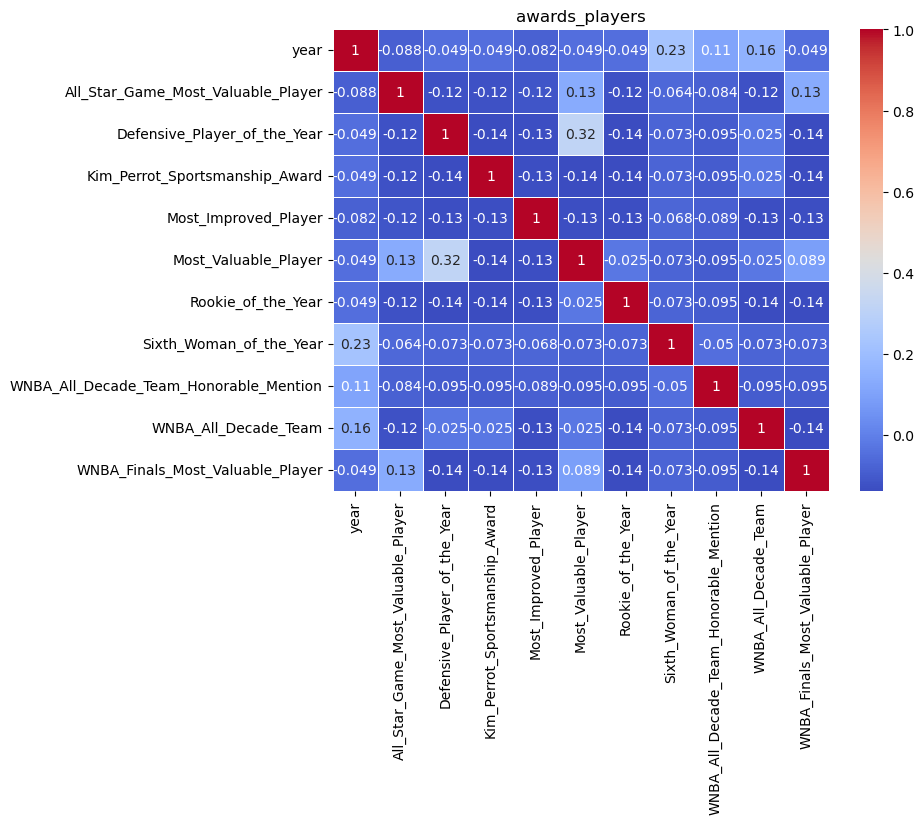

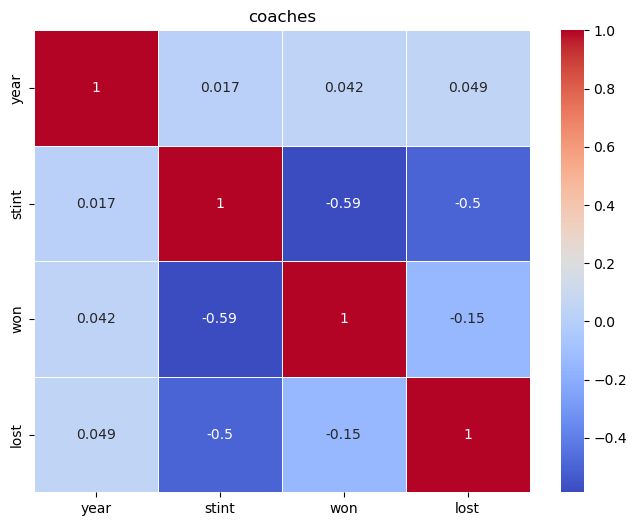

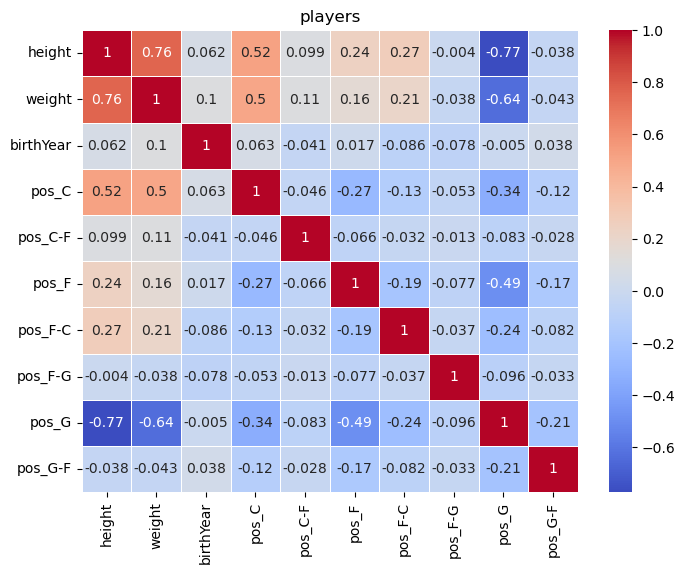

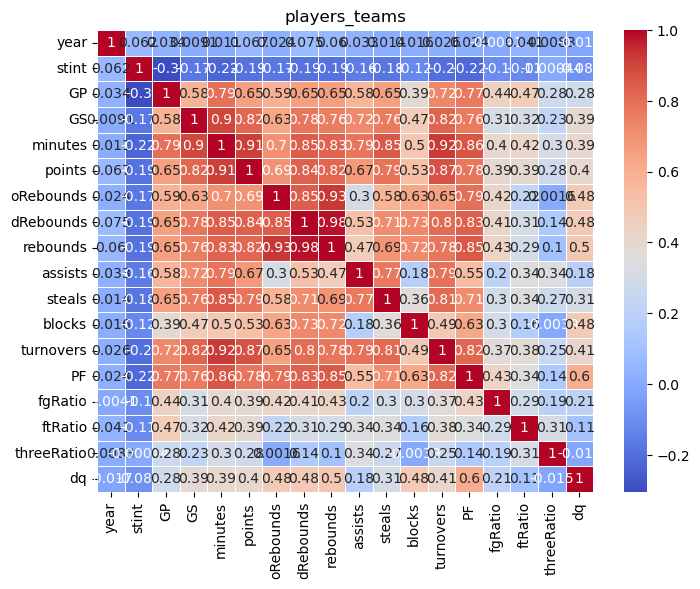

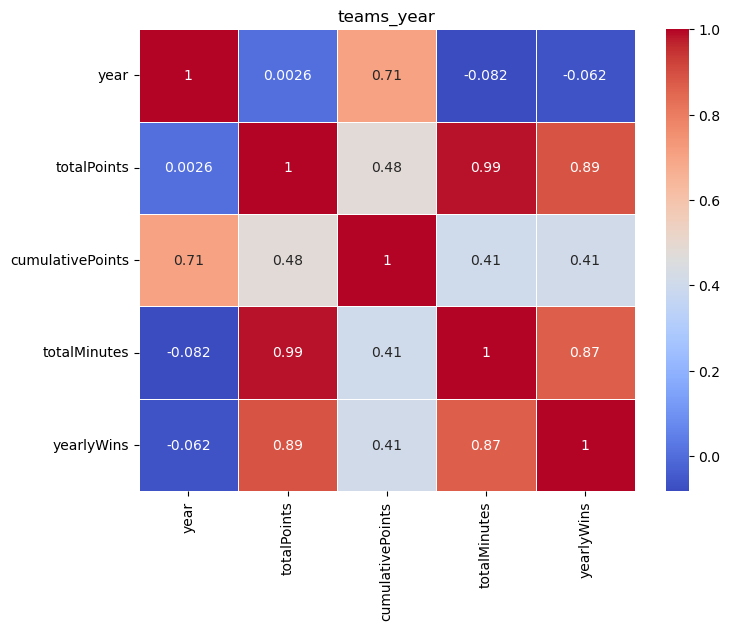

In [17]:
# Removed 'teams' because it has too many columns to be displayed in a heatmap
# 'players_teams' wasn't removed but still hard to read
heatmap_names = ['awards_players', 'coaches', 'players', 'players_teams', 'teams_year'] 

for m in heatmap_names:

    # Compute the correlation matrix
    correlation_matrix = available_dfs[m].corr()
    # print(correlation_matrix)

    # Create a heatmap using Seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title(m)
    plt.show()